# The Mathematical Engineering of Deep Learning

## Practical 4 (Julia version)
**For an R or Python version see the [course website](https://deeplearningmath.org/)**.

# Goals

In this tutorial, we mainly use the MNIST dataset to explore classification using deep neural networks (DNN) models.
At the end of this tutorial, you should be comfortable to use a software package (here `Flux.jl`) to run different models for a classification task.  You will explore different models by exploring/tuning different hyperparamaters of the DNN: 

- number of layers and nodes
- batch normalization
- regularization technique
- dropout 
- weight initialization


# MNIST

**Reminder**: Keep in mind that all features need to be numeric for running a feedforward DNN. When you have some categorical features you have to transform into numerical values such as one-hot encoded. 

In [129]:
using Flux.Data.MNIST

trainLabels = MNIST.labels()
trainImgs = MNIST.images()

testLabels = MNIST.labels(:test)
testImgs = MNIST.images(:test);

In [130]:
@show trainLabels[1]
trainImgs[1]

trainLabels[1] = 5


# Scale the data set

The data is in gray scale with each image having 0 to 255 values. In general we would need to scale it, but Julia does this for us...

In [131]:
typeof(trainImgs[1])

Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [44]:
extrema(Float32.(trainImgs[1]))

(0.0f0, 1.0f0)

# Transform the outcome 

For multi-classification model (multinomial response 0 to 9), `Flux.jl` uses one-hot encoded for the outcome


In [134]:
using Flux: onehotbatch

In [135]:
? onehotbatch

search:



```
onehotbatch(ls, labels[, unk...])
```

Return a `OneHotMatrix` where `k`th column of the matrix is `onehot(ls[k], labels)`.

If one of the input labels `ls` is not found in `labels` and `unk` is given, return [`onehot(unk, labels)`](@ref) ; otherwise the function will raise an error.

# Examples

```jldoctest
julia> Flux.onehotbatch([:b, :a, :b], [:a, :b, :c])
3×3 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0
 1  0  1
 0  0  0
```


In [47]:
onehotbatch(trainLabels,0:9)

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0

# Organize the data

In [137]:
batchSize = 128 #mini-batch size
validateFraction = 0.2 #keep 20% for validation
numTrain = length(trainImgs)
trainRange, validateRange = 1:Int(numTrain*(1-validateFraction)), (Int(numTrain*(1-validateFraction))+1):60000

function minibatch(x, y, indexRange)
    xBatch = Array{Float32}(undef, size(x[1])..., 1, length(indexRange))
    for i in 1:length(indexRange)
        xBatch[:, :, :, i] = Float32.(x[indexRange[i]])
    end
    return (xBatch, onehotbatch(y[indexRange], 0:9))#A tuple of x and y
end

mbIdxs = Iterators.partition(1:length(trainImgs), batchSize)
trainSet = [minibatch(trainImgs, trainLabels, bi) for bi in mbIdxs]
oneBatchTrainSet =  minibatch(trainImgs, trainLabels, 1:length(trainImgs))

validateLabels = MNIST.labels()[validateRange]
validateImgs = MNIST.images()[validateRange]
validateSet = minibatch(validateImgs, validateLabels, 1:length(validateImgs))

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0])

In [139]:
typeof(oneBatchTrainSet)

Tuple{Array{Float32,4},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}}

In [142]:
typeof(trainSet[1])

Tuple{Array{Float32,4},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}}

In [145]:
trainSet[2][1]

28×28×1×128 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [146]:
trainSet[1][2]

10×128 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  1  1  0  1  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  1  0  0  1  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  1
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  1  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0

# Implementation a DNN using `Flux.jl`


In [147]:
using Flux, Flux.Data.MNIST, Statistics, Random, Plots; pyplot()
using Flux: onehotbatch, onecold, crossentropy
Random.seed!(0);

In [148]:
? Dense

search: Dense DenseArray DenseVector DenseMatrix DenseVecOrMat DenseConvDims



```
Dense(in::Integer, out::Integer, σ = identity)
```

Create a traditional `Dense` layer with parameters `W` and `b`.

```
y = σ.(W * x .+ b)
```

The input `x` must be a vector of length `in`, or a batch of vectors represented as an `in × N` matrix. The out `y` will be a vector or batch of length `out`.

# Example

```
julia> d = Dense(5, 2)
Dense(5, 2)

julia> d(rand(5))
2-element Array{Float32,1}:
 -0.16210233
  0.123119034
```


In [161]:
model = Chain(flatten, #Assumes 28x28 input
             Dense(784, 128,relu),
             Dense(128,64,relu),
             Dense(64, 10), softmax)


Chain(flatten, Dense(784, 128, relu), Dense(128, 64, relu), Dense(64, 10), softmax)

In [151]:
testImg = Array{Float32}(undef, 28, 28, 1, 1)
rand!(testImg)

28×28×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.642632   0.500488   0.952353   …  0.561545   0.690352    0.593889
 0.0382713  0.62674    0.909477      0.078818   0.768693    0.691263
 0.53666    0.0226843  0.0852072     0.937394   0.51535     0.949518
 0.651913   0.80515    0.532032      0.925936   0.85998     0.519913
 0.783702   0.0396653  0.488658      0.864002   0.485583    0.985796
 0.400941   0.428303   0.972808   …  0.555855   0.993418    0.176409
 0.944766   0.215189   0.168391      0.0565847  0.606486    0.0623689
 0.395684   0.732655   0.046378      0.594003   0.125206    0.889789
 0.899657   0.75774    0.231964      0.107535   0.0186582   0.90981
 0.10891    0.0417923  0.720433      0.589198   0.00906622  0.153848
 0.9341     0.982689   0.0437049  …  0.218528   0.896509    0.740267
 0.404202   0.958704   0.516564      0.814122   0.710602    0.55893
 0.610032   0.167618   0.351115      0.199022   0.779963    0.209215
 ⋮                                ⋱  ⋮                      


In [152]:
model(testImg)

10×1 Array{Float32,2}:
 0.098156236
 0.09351597
 0.025089001
 0.16187936
 0.08455568
 0.15375611
 0.05485805
 0.17760079
 0.11169337
 0.03889543

In [153]:
length(model)

5

In [154]:
model[1]

flatten (generic function with 1 method)

In [155]:
model[1](testImg) #apply first layer onto test image

784×1 Array{Float32,2}:
 0.6426325
 0.038271308
 0.5366601
 0.6519133
 0.7837024
 0.4009415
 0.94476604
 0.39568412
 0.8996569
 0.10891032
 0.93409956
 0.40420234
 0.61003196
 ⋮
 0.418584
 0.078588724
 0.0010710955
 0.54750013
 0.7606517
 0.44347215
 0.86742604
 0.8810903
 0.38765073
 0.70264184
 0.4799981
 0.6006205

In [156]:
model[1:2](testImg) #apply first two layers

128×1 Array{Float32,2}:
 0.0
 1.6823058
 0.0
 0.0
 0.0
 0.0
 0.0
 1.1247358
 0.040016294
 0.0
 0.3797341
 0.0
 0.0
 ⋮
 0.0
 0.28739774
 0.0
 0.0
 0.0
 0.14597398
 0.0
 2.0804334
 0.0
 0.07807127
 0.15627548
 0.76216686

In [157]:
model[1:3](testImg) #apply first 3 layers

64×1 Array{Float32,2}:
 1.2627497
 0.0
 0.0
 0.6539897
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.23583542
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.3375893
 0.0
 0.013802878
 0.995
 0.0
 1.0714834
 0.13287781
 0.0
 0.0

In [158]:
model[1:4](testImg)

10×1 Array{Float32,2}:
  0.33069757
  0.28226927
 -1.0334334
  0.83098835
  0.18154725
  0.77950466
 -0.25111404
  0.9236753
  0.45989433
 -0.5949863

In [159]:
model[1:5](testImg)

10×1 Array{Float32,2}:
 0.098156236
 0.09351597
 0.025089001
 0.16187936
 0.08455568
 0.15375611
 0.05485805
 0.17760079
 0.11169337
 0.03889543

In [160]:
sum(ans)

1.0f0

### Accuracy and loss

In [162]:
accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))
loss(x, y, model) = crossentropy(model(x), y)

loss (generic function with 1 method)

In [168]:
? @epochs

```
@epochs N body
```

Run `body` `N` times. Mainly useful for quickly doing multiple epochs of training in a REPL.

# Examples

```jldoctest
julia> Flux.@epochs 2 println("hello")
[ Info: Epoch 1
hello
[ Info: Epoch 2
hello
```


In [166]:
? Flux.train!

```
train!(loss, params, data, opt; cb)
```

For each datapoint `d` in `data`, compute the gradient of  `loss` with respect to `params` through backpropagation and call the optimizer `opt`.

If `d` is a tuple of arguments to `loss` call `loss(d...)`, else call `loss(d)`.

A callback is given with the keyword argument `cb`. For example, this will print "training" every 10 seconds (using [`Flux.throttle`](@ref)):

```
train!(loss, params, data, opt, cb = throttle(() -> println("training"), 10))
```

The callback can call [`Flux.stop`](@ref) to interrupt the training loop.

Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.


In [167]:
? Flux.update!

```
update!(x, x̄)
```

Update the array `x` according to `x .-= x̄`.

---

```
update!(opt, p, g)
update!(opt, ps::Params, gs)
```

Perform an update step of the parameters `ps` (or the single parameter `p`) according to optimizer `opt`  and the gradients `gs` (the gradient `g`).

As a result, the parameters are mutated and the optimizer's internal state may change.


In [163]:
η = 0.01 #learning rate 

function trainModel(model;epochs = 25,opt = ADAM(η),verbose = true)
    trainingLosses, validationLosses = [], []
    trainingAccuracy, validationAccuracy = [], []
    
    function updateAfterEpcoh()
        push!(trainingLosses, loss(oneBatchTrainSet..., model))
        push!(validationLosses, loss(validateSet..., model))
        push!(trainingAccuracy,accuracy(oneBatchTrainSet..., model))
        push!(validationAccuracy,accuracy(validateSet..., model))
    end

    model(trainSet[1][1]) #speedup by running once
    for ep in 1:epochs
        #train!() runs a full epoch on all the mini-batches in trainset
        #It pulls from pairs in trainSet as "x" and "y" and use them in the first argument
        Flux.train!((x,y)->loss(x,y,model), params(model), trainSet, opt) #Here is the "beef"
        updateAfterEpcoh()
        verbose && println("$(ep): Validation Accuracy: $(round(last(validationAccuracy),digits=3))")
    end
    return (trainingLosses, validationLosses, trainingAccuracy, validationAccuracy)
end

traces = trainModel(model)
println("\nFinal validation accuracy = ", accuracy(validateSet..., model))

1: Validation Accuracy: 0.963
2: Validation Accuracy: 0.973
3: Validation Accuracy: 0.975
4: Validation Accuracy: 0.969
5: Validation Accuracy: 0.985
6: Validation Accuracy: 0.981
7: Validation Accuracy: 0.985
8: Validation Accuracy: 0.987
9: Validation Accuracy: 0.986
10: Validation Accuracy: 0.991
11: Validation Accuracy: 0.989
12: Validation Accuracy: 0.989
13: Validation Accuracy: 0.993
14: Validation Accuracy: 0.993
15: Validation Accuracy: 0.988
16: Validation Accuracy: 0.989
17: Validation Accuracy: 0.989
18: Validation Accuracy: 0.982
19: Validation Accuracy: 0.989
20: Validation Accuracy: 0.994
21: Validation Accuracy: 0.991
22: Validation Accuracy: 0.991
23: Validation Accuracy: 0.99
24: Validation Accuracy: 0.987
25: Validation Accuracy: 0.986

Final validation accuracy = 0.9865


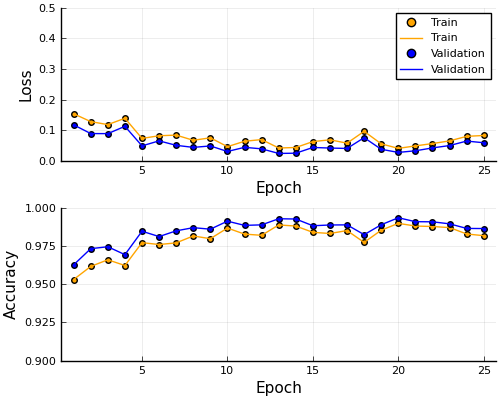

In [164]:
function plotModel(traces)
    trainingLosses, validationLosses = traces[1], traces[2]
    trainingAccuracy, validationAccuracy = traces[3], traces[4]

    p1 = plot(trainingLosses,label="Train", ylim=(0.0,0.5), xlabel="Epoch", 
            ylabel = "Loss",c=:orange,seriestype = [:scatter,:line])
         plot!(validationLosses,label="Validation",c=:blue,seriestype = [:scatter,:line])

    p2 = plot(trainingAccuracy,label="Train", ylim=(0.9,1.0), xlabel="Epoch", 
            ylabel = "Accuracy",legend=false,c=:orange,seriestype = [:scatter,:line])
         plot!(validationAccuracy,label="Validation",c=:blue,seriestype = [:scatter,:line])

    plot(p1,p2,layout=(2,1),size=(500,400))
end

plotModel(traces)

We can see that the loss function improves rapidly. However, we can see a potential overfit after 10 epochs. Indeed, the accurary rate of the validation set presents a flat shape after 10 epochs.

# Considering the test set

In [63]:
#creating a predictor function (packaging the neural network)
exampleImage = testImgs[1]

In [64]:
testImg = Array{Float32}(undef, 28, 28, 1, 1)
testImg[:,:,1,1] = exampleImage;
testImg

28×28×1×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.329412     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.870588     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.262745     0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0       …  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0          0.0  0.0  0.0  0.0  0.0  0.0
 ⋮      

In [65]:
exampleModelOutput = model(testImg)

10×1 Array{Float32,2}:
 0.0
 3.361f-40
 4.5305f-41
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0840842f-35

In [66]:
#Another way is to put it in a 784x1 matrix/array
testImg2 = reshape(Float32.(exampleImage),784,1)

784×1 Array{Float32,2}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [67]:
model(testImg2)

10×1 Array{Float32,2}:
 0.0
 3.361f-40
 4.5305f-41
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0840842f-35

### Creating a predictor function

In [68]:
onecold(exampleModelOutput)

1-element Array{Int64,1}:
 8

In [69]:
first(onecold(exampleModelOutput)) - 1

7

In [70]:
#Our own "predictor" function based on a trained model
predictor(img,model) = first(onecold(model(reshape(Float32.(img),784,1))))-1

predictor (generic function with 1 method)

In [71]:
predictor(exampleImage,model)

7

In [72]:
preds = [predictor(img,model) for img in testImgs]

10000-element Array{Int64,1}:
 7
 2
 1
 0
 4
 1
 4
 9
 5
 9
 0
 6
 9
 ⋮
 5
 6
 7
 8
 9
 0
 1
 2
 3
 4
 5
 6

In [73]:
testAccuracy = sum(preds .== testLabels)/length(preds)

0.9683

In [74]:
confusionMatrix = 
    [sum([predictor(img,model) .== i for img in testImgs[testLabels .== j]]) 
        for i in 0:9, j in 0:9]

10×10 Array{Int64,2}:
 970     0     0    0    3    3    2    1    4    1
   1  1123     2    0    0    2    3    9    2    2
   1     5  1003    5    4    1    1   12    4    1
   0     0     6  948    0    3    0    0    0    0
   0     1     1    0  933    0    0    1    3    6
   3     0     2   31    0  856   11    0    9    1
   2     2     0    0   11    9  939    0    1    1
   2     0     8    9    2    4    1  999    7   15
   0     4    10   13    3    7    1    2  935    5
   1     0     0    4   26    7    0    4    9  977

In [75]:
using LinearAlgebra
sum(diag(confusionMatrix))/length(preds)

0.9683

## Improve our model by tuning some parameters 


### Model complexity

We will explore different model size by playing with the number of hidden layer from 1 to 3 and different number of neurons. Complex models have higher capacity to learn more features and patterns in the data, however they can overfit the training data. We try to maximize a high validation performance while minimizing the complexity of our model. The folowing table present the 9 models we will explore:


In [170]:
typeof(:person)

Symbol

In [171]:
models

Dict{Tuple{Symbol,Int64},Array{Int64,1}} with 9 entries:
  (:large, 3)  => [256, 128, 64]
  (:medium, 3) => [64, 32, 16]
  (:small, 2)  => [16, 8]
  (:small, 3)  => [16, 8, 4]
  (:large, 2)  => [256, 128]
  (:medium, 1) => [64]
  (:small, 1)  => [16]
  (:medium, 2) => [64, 32]
  (:large, 1)  => [256]

In [172]:
sizes = [:small, :medium, :large]
layers = [1,2,3]
models = Dict{Tuple{Symbol,Int64},Array{Int64,1}}()
models[(:small,1)] = [16] ; models[(:small,2)] = [16,8] ;  models[(:small,3)] = [16,8,4]
models[(:medium,1)] = [64] ; models[(:medium,2)] = [64,32] ;  models[(:medium,3)] = [64,32,16]
models[(:large,1)] = [256] ; models[(:large,2)] = [256,128] ;  models[(:large,3)] = [256,128,64]

function makeModel(size,layers) 
    functions = []
    push!(functions,flatten)
    architecture = models[(size,layers)]
    prevNeurons = 784
    for l in 1:layers
        neurons = architecture[l]
        push!(functions,Dense(prevNeurons,neurons,relu))
        prevNeurons = neurons
    end
    push!(functions,Dense(prevNeurons,10))
    push!(functions,softmax)
    return Chain(functions...)
end

display([models[(s,l)] for s in sizes, l in layers])

makeModel(:medium,3)

3×3 Array{Array{Int64,1},2}:
 [16]   [16, 8]     [16, 8, 4]
 [64]   [64, 32]    [64, 32, 16]
 [256]  [256, 128]  [256, 128, 64]

Chain(flatten, Dense(784, 64, relu), Dense(64, 32, relu), Dense(32, 16, relu), Dense(16, 10), softmax)

1: Validation Accuracy: 0.934
2: Validation Accuracy: 0.969
3: Validation Accuracy: 0.987
4: Validation Accuracy: 0.984
5: Validation Accuracy: 0.988
6: Validation Accuracy: 0.992
7: Validation Accuracy: 0.989
8: Validation Accuracy: 0.992
9: Validation Accuracy: 0.988
10: Validation Accuracy: 0.992
11: Validation Accuracy: 0.997
12: Validation Accuracy: 0.997
13: Validation Accuracy: 0.995
14: Validation Accuracy: 0.995
15: Validation Accuracy: 0.993
16: Validation Accuracy: 0.994
17: Validation Accuracy: 0.998
18: Validation Accuracy: 0.997
19: Validation Accuracy: 0.997
20: Validation Accuracy: 0.998


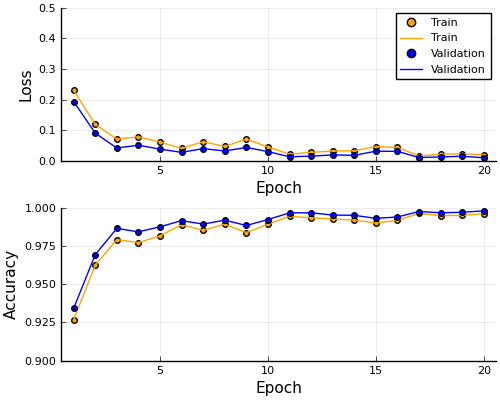

In [179]:
model = makeModel(:large,3)
traces = trainModel(model,epochs = 20, opt = RMSProp(0.002))
plotModel(traces)

# Batch Normalization

In [38]:
? BatchNorm

search: BatchNorm batched_transpose



```
BatchNorm(channels::Integer, σ = identity;
          initβ = zeros, initγ = ones,
          ϵ = 1e-8, momentum = .1)
```

[Batch Normalization](https://arxiv.org/abs/1502.03167) layer. `channels` should be the size of the channel dimension in your data (see below).

Given an array with `N` dimensions, call the `N-1`th the channel dimension. (For a batch of feature vectors this is just the data dimension, for `WHCN` images it's the usual channel dimension.)

`BatchNorm` computes the mean and variance for each each `W×H×1×N` slice and shifts them to have a new mean and variance (corresponding to the learnable, per-channel `bias` and `scale` parameters).

Use [`testmode!`](@ref) during inference.

# Examples

```julia
m = Chain(
  Dense(28^2, 64),
  BatchNorm(64, relu),
  Dense(64, 10),
  BatchNorm(10),
  softmax)
```


In [176]:
model= Chain(flatten, 
             Dense(784, 128,relu),
             BatchNorm(128),
             Dense(128,64,relu),
             BatchNorm(64),
             Dense(64, 10), softmax)
traces = trainModel(model)
println("\nFinal validation accuracy = ", accuracy(validateSet..., model))

1: Validation Accuracy: 0.965
2: Validation Accuracy: 0.975
3: Validation Accuracy: 0.982
4: Validation Accuracy: 0.988
5: Validation Accuracy: 0.988
6: Validation Accuracy: 0.989
7: Validation Accuracy: 0.991
8: Validation Accuracy: 0.992
9: Validation Accuracy: 0.992
10: Validation Accuracy: 0.995
11: Validation Accuracy: 0.992
12: Validation Accuracy: 0.992
13: Validation Accuracy: 0.995
14: Validation Accuracy: 0.996
15: Validation Accuracy: 0.994
16: Validation Accuracy: 0.994
17: Validation Accuracy: 0.995
18: Validation Accuracy: 0.994
19: Validation Accuracy: 0.996
20: Validation Accuracy: 0.996
21: Validation Accuracy: 0.994
22: Validation Accuracy: 0.996
23: Validation Accuracy: 0.996
24: Validation Accuracy: 0.996
25: Validation Accuracy: 0.995

Final validation accuracy = 0.9948333333333333


In [79]:
preds = [predictor(img,model) for img in testImgs]
testAccuracy = sum(preds .== testLabels)/length(preds)

0.9747

## Dropout

An another avenue for overfitting issue is to use the **dropout** strategy.

This code is taken from [here](https://github.com/h-Klok/StatsWithJuliaBook/blob/master/9_chapter/dropout.jl)

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 5
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 6
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 8
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 9
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 10
└ @ Main /Users/uqjnazar/.julia/packages/

┌ Info: Epoch 27
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 28
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 29
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 30
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 5
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 6
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /Users/uqjnazar/.julia/packages

┌ Info: Epoch 24
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 25
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 26
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 27
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 28
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 29
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 30
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/uqjnazar/.julia/packa

┌ Info: Epoch 21
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 22
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 23
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 24
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 25
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 26
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 27
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 28
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 29
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 30
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/pa

┌ Info: Epoch 18
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 19
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 20
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 21
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 22
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 23
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 24
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 25
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 26
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 27
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 28
└ @ Main /Users/uqjnazar/.julia/p

┌ Info: Epoch 15
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 16
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 17
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 18
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 19
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 20
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 21
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 22
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 23
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 24
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 25
└ @ Main /Users/uqjnazar/.julia/p

┌ Info: Epoch 12
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 13
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 14
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 15
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 16
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 17
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 18
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 19
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 20
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 21
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 22
└ @ Main /Users/uqjnazar/.julia/p

┌ Info: Epoch 9
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 10
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 11
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 12
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 13
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 14
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 15
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 16
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 17
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 18
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 19
└ @ Main /Users/uqjnazar/.julia/pa

┌ Info: Epoch 6
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 8
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 9
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 10
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 11
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 12
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 13
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 14
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 15
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 16
└ @ Main /Users/uqjnazar/.julia/packa

┌ Info: Epoch 3
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 5
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 6
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 8
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 9
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 10
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 11
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 12
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 13
└ @ Main /Users/uqjnazar/.julia/packages

┌ Info: Epoch 30
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 5
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 6
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 8
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 9
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 10
└ @ Main /Users/uqjnazar/.julia/packages/F

┌ Info: Epoch 27
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 28
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 29
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 30
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 5
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 6
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 7
└ @ Main /Users/uqjnazar/.julia/packages

┌ Info: Epoch 24
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 25
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 26
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 27
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 28
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 29
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 30
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 2
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 3
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 4
└ @ Main /Users/uqjnazar/.julia/packa

┌ Info: Epoch 21
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 22
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 23
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 24
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 25
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 26
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 27
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 28
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 29
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 30
└ @ Main /Users/uqjnazar/.julia/packages/Flux/05b38/src/optimise/train.jl:114
┌ Info: Epoch 1
└ @ Main /Users/uqjnazar/.julia/pa

The best dropout probability is 0.25.
It achieves 0.856 accuracy on average.


┌ Warning: Keyword argument hover not supported with Plots.PyPlotBackend().  Choose from: Set([:zforeground_color_guide, :top_margin, :group, :background_color, :stride, :yforeground_color_text, :yguidefontcolor, :seriesalpha, :legendfontcolor, :seriescolor, :ztick_direction, :zlims, :overwrite_figure, :normalize, :linestyle, :xflip, :yforeground_color_guide, :fillcolor, :ygrid, :background_color_inside, :bins, :yscale, :clims, :xtickfontcolor, :xguide, :fillalpha, :tick_direction, :yguidefontsize, :legendfontfamily, :foreground_color, :x, :legend, :discrete_values, :ytick_direction, :ribbon, :xdiscrete_values, :legendtitle, :xgridstyle, :orientation, :gridstyle, :markersize, :camera, :xforeground_color_grid, :quiver, :zticks, :markerstrokecolor, :xtickfontsize, :levels, :zgridstyle, :foreground_color_border, :marker_z, :markerstrokealpha, :markeralpha, :zguidefontcolor, :ygridlinewidth, :zlink, :zscale, :smooth, :xticks, :zguidefontsize, :y, :margin, :ytickfontcolor, :title_location, 

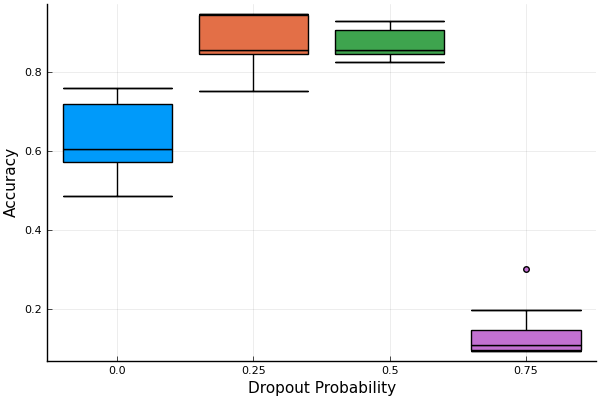

In [103]:
using Flux, Flux.Data.MNIST, Statistics, BSON, Random, StatsPlots; pyplot()
using Flux: onehotbatch, onecold, crossentropy, @epochs

epochs = 30
eta = 1e-3
batchSize = 200
trainRange, validateRange = 1:1000, 1001:5000

function minibatch(x, y, idxs)
    xBatch = Array{Float32}(undef, size(x[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        xBatch[:, :, :, i] = Float32.(x[idxs[i]])
    end
    return (xBatch, onehotbatch(y[idxs], 0:9))
end

trainLabels = MNIST.labels()[trainRange]
trainImgs = MNIST.images()[trainRange]
mbIdxs = Iterators.partition(1:length(trainImgs), batchSize)
trainSet = [minibatch(trainImgs, trainLabels, i) for i in mbIdxs]

validateLabels = MNIST.labels()[validateRange]
validateImgs = MNIST.images()[validateRange]
validateSet = minibatch(validateImgs, validateLabels, 1:length(validateImgs))

accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))
loss(x, y, model) = crossentropy(model(x), y)

function evalAccuracy(dropP)
    model= Chain(Conv((5, 5), 1=>8, relu), MaxPool((2,2)),  #Convolutional layers - topic of next lecture
                    Conv((3, 3), 8=>16, relu), MaxPool((2,2)),
                    flatten,
                    Dense(400, 200,relu), 
                    Dropout(dropP),
                    Dense(200, 200,relu), Dropout(dropP),
                    Dense(200, 200,relu), Dropout(dropP),
                    Dense(200, 10,relu), Dropout(dropP),
                    softmax)
    opt = ADAM(eta);
    @epochs epochs Flux.train!((x,y)->loss(x,y,model),params(model),trainSet,opt)  #HERE Is the "TOFU"
    accuracy(validateSet..., model)
end

pToTest = [0.0, 0.25, 0.5, 0.75]
n = 10
results = [[evalAccuracy(p) for _ in 1:n] for p in pToTest]
bestAcc, bestI = findmax(median.(results))
println("The best dropout probability is $(pToTest[bestI]).")
println("It achieves $(bestAcc) accuracy on average.")

boxplot(results,label="",
       xticks=([1:1:4;],string.(pToTest)),
       xlabel="Dropout Probability", ylabel = "Accuracy", legend = false)

### Early stop

In [124]:
batchSize = 128
validateFraction = 0.5  #!!!!!
numTrain = length(trainImgs)
trainRange, validateRange = 1:Int(round(numTrain*(1-validateFraction))), (Int(round(numTrain*(1-validateFraction)))+1):60000

function minibatch(x, y, indexRange)
    xBatch = Array{Float32}(undef, size(x[1])..., 1, length(indexRange))
    for i in 1:length(indexRange)
        xBatch[:, :, :, i] = Float32.(x[indexRange[i]])
    end
    return (xBatch, onehotbatch(y[indexRange], 0:9))#A tuple of x and y
end

mbIdxs = Iterators.partition(1:length(trainImgs), batchSize)
trainSet = [minibatch(trainImgs, trainLabels, bi) for bi in mbIdxs]
oneBatchTrainSet =  minibatch(trainImgs, trainLabels, 1:length(trainImgs))

validateLabels = MNIST.labels()[validateRange]
validateImgs = MNIST.images()[validateRange]
validateSet = minibatch(validateImgs, validateLabels, 1:length(validateImgs));

In [127]:
model= Chain(flatten, 
             Dense(784, 300,relu),
             Dense(300, 200,relu),
             Dense(200, 128,relu),
             Dense(128,64,relu),
             Dense(64, 10), softmax)
traces = trainModel(model,epochs=50,opt=ADAM(0.002))
println("\nFinal validation accuracy = ", accuracy(validateSet..., model))

1: Validation Accuracy: 0.725
2: Validation Accuracy: 0.785
3: Validation Accuracy: 0.815
4: Validation Accuracy: 0.831
5: Validation Accuracy: 0.857
6: Validation Accuracy: 0.857
7: Validation Accuracy: 0.866
8: Validation Accuracy: 0.874
9: Validation Accuracy: 0.882
10: Validation Accuracy: 0.883
11: Validation Accuracy: 0.884
12: Validation Accuracy: 0.885
13: Validation Accuracy: 0.885
14: Validation Accuracy: 0.886
15: Validation Accuracy: 0.886
16: Validation Accuracy: 0.886
17: Validation Accuracy: 0.886
18: Validation Accuracy: 0.886
19: Validation Accuracy: 0.886
20: Validation Accuracy: 0.886
21: Validation Accuracy: 0.886
22: Validation Accuracy: 0.886
23: Validation Accuracy: 0.886
24: Validation Accuracy: 0.886
25: Validation Accuracy: 0.886
26: Validation Accuracy: 0.886
27: Validation Accuracy: 0.886
28: Validation Accuracy: 0.886
29: Validation Accuracy: 0.886
30: Validation Accuracy: 0.886
31: Validation Accuracy: 0.886
32: Validation Accuracy: 0.886
33: Validation Ac

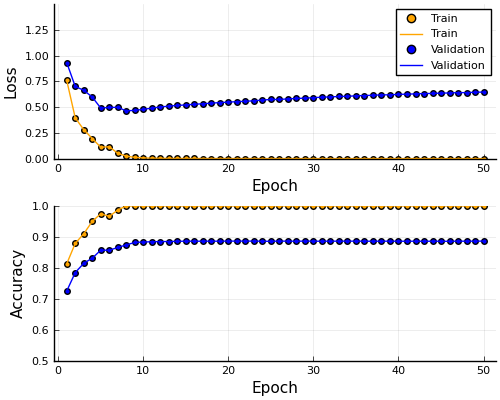

In [128]:
function plotModel(traces)
    trainingLosses, validationLosses = traces[1], traces[2]
    trainingAccuracy, validationAccuracy = traces[3], traces[4]

    p1 = plot(trainingLosses,label="Train", ylim=(0.0,1.5), xlabel="Epoch", 
            ylabel = "Loss",c=:orange,seriestype = [:scatter,:line])
         plot!(validationLosses,label="Validation",c=:blue,seriestype = [:scatter,:line])

    p2 = plot(trainingAccuracy,label="Train", ylim=(0.5,1.0), xlabel="Epoch", 
            ylabel = "Accuracy",legend=false,c=:orange,seriestype = [:scatter,:line])
         plot!(validationAccuracy,label="Validation",c=:blue,seriestype = [:scatter,:line])

    plot(p1,p2,layout=(2,1),size=(500,400))
end

plotModel(traces)

In this case we would prefer to "early stop" and get the parameters trained at around Epcoh 10 - more on that in the next practical...